# Classification runthrough
#### by Alvin Zhang
##### Notes and examples based on Bishop's "Pattern Recognition and Machine Learning"

Generalized linear model: $y(\vec{x})=f(\vec{w}^T\phi(\vec{x})+w_0)$

## Discriminant Functions (linear)

In this section, we look at different linear discriminant functions using three types of methods: least squares, linear discriminant analysis (Fisher's LD), and the perceptron.

### Least squares

#### Two Classes

Suppose we have the following dataset.

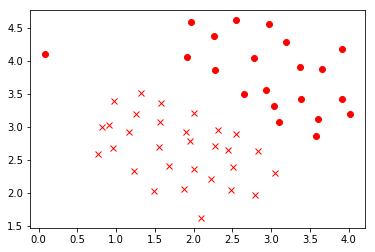

In [1]:
import numpy as np
from matplotlib import pyplot as plt


def plot_c_data(fig, X, t):
    """
    Plots classification data.
    Args:
        fig (figure): figure to plot on
        X (float ndarray): x values to plot
        t (float ndarray): corresponding classes to X
    """
    markers = ['rx', 'ro', 'r+', 'r^', 'r.']
    for i, c in enumerate(np.unique(t)):
        fig.plot(X[np.where(t==c)[0], [0]], X[np.where(t==c)[0], [1]], markers[i])

file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

Each class $C_k$ is described by its own linear model, $y_k(\vec{x})=\vec{w}_k^T\vec{x}+w_{k_0}$. We can group these functions together so that $$\vec{y}(\vec{x})=\tilde{\mathbf{W}}^T\tilde{\vec{x}}$$
where 
$$\tilde{\mathbf{W}}=
\begin{bmatrix}
| &   & | \\
\tilde{\vec{w_1}} &  \dots & \tilde{\vec{w_K}} \\
| &   & |
\end{bmatrix}$$
and $\tilde{\vec{x}}=(1,\vec{x}^T)^T$. <br>
Now suppose we have a training dataset, comprised of input

$$\tilde{\mathbf{X}}=
\begin{bmatrix}
{-} &  \tilde{\vec{x_1}}^T & -  \\
\  &  \vdots & \ \\
{-} &  \tilde{\vec{x_N}}^T  & - \\
\end{bmatrix}$$


and target

$$\mathbf{T}=
\begin{bmatrix}
{-} &  \tilde{\vec{t_1}}^T & -  \\
  &  \vdots &  \\
{-} & \tilde{\vec{t_N}}^T  & -
\end{bmatrix}$$
The sum-of-squares error function is then given by
$$ E_D(\tilde{\mathbf{W}})=\frac{1}{2}\textrm{Tr}\left((\tilde{\mathbf{X}}\tilde{\mathbf{W}}-\mathbf{T})^T(\tilde{\mathbf{X}}\tilde{\mathbf{W}}-\mathbf{T})\right)$$
If we set the derivative w.r.t. $\tilde{\mathbf{W}}$ to zero, we find that 
$$\tilde{\mathbf{W}} = (\tilde{\mathbf{X}}^T\tilde{\mathbf{X}})^{-1}\tilde{\mathbf{X}}^T\mathbf{T}$$
Since least squares lacks robustness to outliers, we can add a regularization term so that 
$$\tilde{\mathbf{W}} = (\lambda\mathbf{I}+\tilde{\mathbf{X}}^T\tilde{\mathbf{X}})^{-1}\tilde{\mathbf{X}}^T\mathbf{T}$$

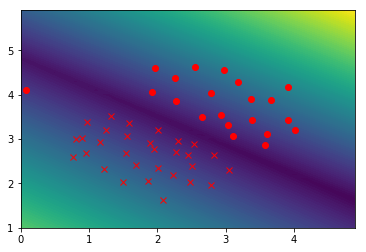

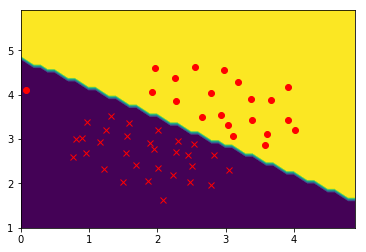

In [2]:
class LSQClassifier():
    def __init__(self, X, t):
        """
        Initializes Least Squares Classifier object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.N, self.D = self.X.shape
        self.K = len(np.unique(t))
        self.T = self._1_of_K(t)
        
        
        self.W = None

    def _1_of_K(self, t):
        """
        Converts a target array to a 1-of-K coding scheme.
        Args:
            t (float ndarray): target values (t:{0, 1,...})
        Returns:
            T (float ndarray): target values in 1-of-K scheme
        """
        T = np.zeros((self.N, self.K))
        for i in range(self.N):
            T[i, int(t[i])] = 1
        return T

    def fit(self, lam=1):
        """
        Gets weight parameters.
        Args:
            lam (float): regularization coefficient
        Returns:
            W (float ndarray): weights found by normal equation
        """
        self.W = np.linalg.pinv(lam * np.identity(self.D) + 
                                self.X.T.dot(self.X)).dot(self.X.T).dot(self.T)
        return self.W
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.W is not None, 'Need to fit first.' 
        x = np.hstack((np.ones((x.shape[0], 1)), x))
        y = self.W.T.dot(x.T)
        pred, val = np.argmax(y), np.max(y)
        return pred, val


def plot_contour(fig, x_coord, y_coord, clas, grad=True, levels=100):
    """
    Plots contours for classification data.
    Args:
        fig (figure): figure to plot on
        x_coord (float iterable): x coordinate range
        y_coord (float iterable): y coordinate range
        clas (classifier): classifier object with 'pred' function
    """
    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    Z_coord = np.zeros(X_coord.shape)
    for i in range(X_coord.shape[0]):
        for j in range(X_coord.shape[1]):
            x = np.asarray([[X_coord[i, j], Y_coord[i, j]]])
            Z_coord[i, j] = clas.pred(x)[grad]
    fig.contourf(X_coord, Y_coord, Z_coord, levels)


def plot_contour_both(fig, x_coord, y_coords, clas):
    """
    Plots contour for classification both with and without gradient.
    Args:
        fig (figure): figure to plot on
        x_coord (float ndarray): x values to plot
        y_coord (float ndarray): y values to plot
        clas (classifier): classifier with pred functions
    """
    plot_contour(fig, x_coord, y_coord, clas)
    plot_c_data(fig, X, t)
    fig.show()
    plot_contour(fig, x_coord, y_coord, clas, grad=False)
    plot_c_data(fig, X, t)
    fig.show()


clas = LSQClassifier(X, t)
clas.fit()

x_coord = np.arange(0, 5, 0.1)
y_coord = np.arange(1, 6, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

#### >2 classes

We will see that the least squares approach works really poorly with more than two classes.

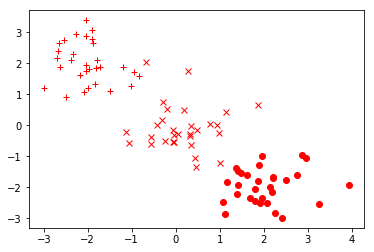

In [3]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

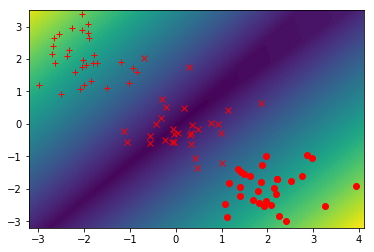

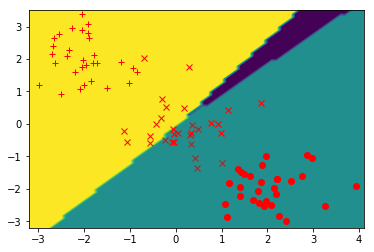

In [4]:
clas = LSQClassifier(X, t)
clas.fit()

x_coord = np.arange(-3.2, 4.2, 0.1)
y_coord = np.arange(-3.2, 3.6, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

The reason for these failures is because least squares corresponds to maxmimum likelihood under the assumption of a Gaussian conditional distribution, while the binary target vectors have a [Bernoulli] distribution that is very different from Gaussian.

### Fisher's Linear Discriminant

Linear discriminant analysis views classification in terms of dimensionality reduction. We take a $D$ dimensional $\vec{x}$ and project it down to $D'$ and place thresholds to determine the class. It is very similar to PCA, except this is a supervised learning problem, whereas PCA is unsupervised.

#### Two classes

Suppose we have the following dataset again

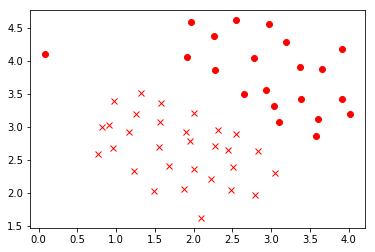

In [5]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

In this case, $\vec{x}$ only has two dimensions, so we have to reduce it to one dimension. Our goal is to find a suitable weight vector so that $y=\vec{w}^T\vec{x} \geq -w_0$ can accurately predict the class for some threshold $-w_0$. <br>
More specifically, we want to choose a $\vec{w}$ that maximizes the difference after we reduce the dimension (i.e. maximize $m_2-m_1=\vec{w}(\vec{m}_2-\vec{m}_1)$). Since we can maximize this by making $\vec{w}$ arbitrarily large, we also have to constrain $\vec{w}$, say, to a unit vector. Along with maximizing this difference, we also must minimize the differences within each class after the transformation. For each class $C_k$, this can be represented as $s_k^2=\sum_{n\in{C_k}}(y_n-m_k)^2$, <br> All of this can be represented in the Fisher criterion: 
$$ J(\vec{w}) =\frac{(m_2-m_1)^2}{s_1^2+s_2^2}=\frac{\vec{w}^T\mathbf{S}_B\vec{w}}{\vec{w}^T\mathbf{S}_W\vec{w}} $$
where $\mathbf{S}_B=(\vec{m}_2-\vec{m}_1)(\vec{m}_2-\vec{m}_1)^T$ is the between-class covariance we hope to maximize, and $\mathbf{S}_W=\sum_{n\in{C_1}}(\vec{x}_n-\vec{m}_1)(\vec{x}_n-\vec{m}_1)^T + \sum_{n\in{C_2}}(\vec{x}_n-\vec{m}_2)(\vec{x}_n-\vec{m}_2)^T$ is the within-class covariance we hope to minimize.<br> <br>
All-in-all, this means that we want to maximize $J$. Differentiating $J(\vec{w})$ w.r.t $\vec{w}$, we get that 
$$\vec{w}\propto\mathbf{S}_W^{-1}(\vec{m}_2-\vec{m}_1)$$


In [6]:
from scipy.stats import norm as sv_gauss


class BinaryLDA:
    def __init__(self, X, t):
        """
        Initializes BinaryLDA object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.X1 = X[np.where(t==0)[0], :]
        self.X2 = X[np.where(t==1)[0], :]
        self.N1, self.N2 = self.X1.shape[0], self.X2.shape[0]
        self.t = t
        self.w = None

    def _get_means(self):
        """
        Computes mean for each class.
        Returns:
            m1 (float ndarray): mean for first class
            m2 (float ndarray): mean for second class
        """
        m1 = np.average(self.X1, axis=0).reshape(-1, 1)
        m2 = np.average(self.X2, axis=0).reshape(-1, 1)
        return m1, m2

    def _get_variances(self):
        """
        Computes covariances.
        Returns:
            S_B (float ndarray): between-class covariance
            S_W (float ndarray): within-class covariance
        """
        m1, m2 = self._get_means()
        S_B = (m2-m1).dot((m2-m1).T)
        S_W = (self.X1-m1.T).T.dot((self.X1-m1.T)) +\
              (self.X2-m2.T).T.dot((self.X2-m2.T))
        return S_B, S_W
    
    def _get_cc(self):
        """
        Computes class conditionals for model.
        Returns:
            p_y_C1 (sv_gauss): class conditional for first class
            p_y_C2 (sv_gauss): class conditional for second class
        """
        y1 = self.X1.dot(self.w)
        y2 = self.X2.dot(self.w)
        ym1 = np.average(y1)
        ym2 = np.average(y2)
        yv1 = (1/(self.N1-1)) * (y1-ym1.T).T.dot(y1-ym1.T)[0][0]
        yv2 = (1/(self.N2-1)) * (y2-ym2.T).T.dot(y2-ym2.T)[0][0]
        p_y_C1 = sv_gauss(ym1, np.sqrt(yv1))
        p_y_C2 = sv_gauss(ym2, np.sqrt(yv2))
        return p_y_C1, p_y_C2

    def fit(self):
        """
        Computes parameters for model.
        Returns:
            w (float ndarray): weight parameters
        """
        m1, m2 = self._get_means()
        S_B, S_W = self._get_variances()
        self.w = np.linalg.inv(S_W).dot(m2-m1)
        self.w = self.w/np.linalg.norm(self.w)
        return self.w
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w is not None, 'Need to fit first'
        p_y_C1, p_y_C2 = self._get_cc()
        y = x.dot(self.w)[0]
        pred, val = np.argmax([p_y_C1.pdf(y), p_y_C2.pdf(y)]), np.max([p_y_C1.pdf(y), p_y_C2.pdf(y)])
        return pred, val

    
clas = BinaryLDA(X, t)
clas.fit()
clas.w

array([[ 0.48117631],
       [ 0.87662384]])

Having found optimal $\vec{w}$, we have to find the threshold. To do this, we fit a Gaussian model to both $y(\vec{x}|C_1)$ and $y(\vec{x}|C_2)$. This is shown above in the `get_cc` (get class conditional) function. From decision theory, we know that we choose $k$ such that $p(y|C_k)$ is the largest. However, for two Gaussians, we can just find the intersection to explicitly find the threshold. We set the two Gaussians equal to each other and solve the quadratic equation (after taking the logarithm). This is really messy, and there are better methods for real world implementation, but this is a pretty intuitive way.

In [7]:
def quad_form(a, b, c):
    return (-b + (b**2 - 4*a*c)**.5)/(2*a), (-b - (b**2 - 4*a*c)**.5)/(2*a)

p_y_C1, p_y_C2, = clas._get_cc()
ym1, yv1 = p_y_C1.mean(), p_y_C1.var()
ym2, yv2 = p_y_C2.mean(), p_y_C2.var()
a = 1/2 * (1/yv2-1/yv1)
b = ym1/yv1 - ym2/yv2
c = ym2**2 / (2*yv2) - ym1**2/(2*yv1) - np.log((yv1/yv2)**0.5)
quad_form(a, b, c)

(-4.7343396652007099, 3.9268539847708706)

From observing

In [8]:
y1 = clas.X1.dot(clas.w)[0:3]
y2 = clas.X2.dot(clas.w)[0:3]
y1, y2

(array([[ 3.70549594],
        [ 3.77592386],
        [ 3.38037674]]), array([[ 4.97387481],
        [ 4.4776242 ],
        [ 5.43486666]]))

the threshold is obviously the positive term (3.927).

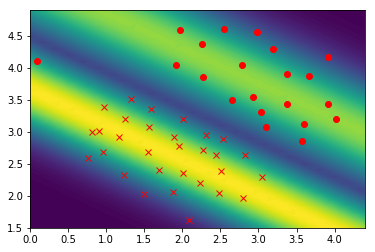

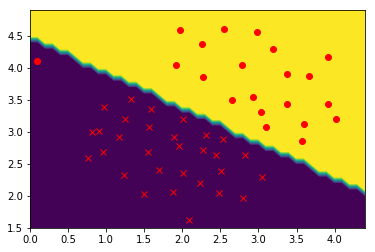

In [9]:
x_coord = np.arange(0, 4.5, 0.1)
y_coord = np.arange(1.5, 5, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

#### >2 classes

We have this dataset again, and we want to extend LDA to more than two classes.

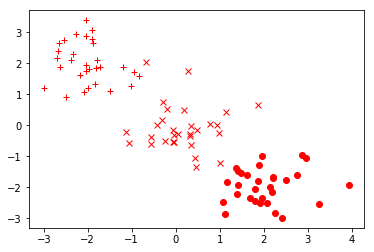

In [10]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X,t)
plt.show()

Again, we are reducing this dataset to one dimension, but if we had a dataset that were reducing it to $D'>1$ dimensions, we have 
$$\vec{y}=\mathbf{W}^T\vec{x}$$
where 
$$\tilde{\mathbf{W}}=
\begin{bmatrix}
 | &  &  | \\
 \vec{w}_1 &  \dots & \vec{w}_{D'} \\
 | &  &  |
\end{bmatrix}$$

As before, we want to calculate the between-class covariance and within-class covariance. The within-class covariance is given by
$$\mathbf{S}_W=\sum_{k=1}^K\mathbf{S}_k$$
where
$$\mathbf{S}_k=\sum_{n\in{C_k}}(\vec{x}_n-\vec{m}_k)(\vec{x}_n-\vec{m}_k)^T$$
$$\vec{m}_k=\frac{1}{N_k}\sum_{n\in{C_k}}\vec{x}_n$$
To find a generalization of the between-class covariance, we first turn to the total covariance
$$\mathbf{S}_T=\sum_{n=1}^N(\vec{x}_n-\vec{m})(\vec{x}_n-\vec{m})^T$$
where $\vec{m}=\frac{1}{N}\sum_{n=1}^{N}\vec{x}_n$. 
<br>The between-class covariance is then given by $\mathbf{S}_T-\mathbf{S}_W$, or explictly,
$$\mathbf{S}_B=\sum_{n=1}^{K}N_k(\vec{m}_k-\vec{m})(\vec{m}_k-\vec{m})^T$$

Since we want to optimize within the projected space, we have to redefine these in the $D'$ dimensional space. These covariances are given by
$$\mathbf{s}_W=\sum_{k=1}^K\sum_{n\in{C_k}}(\vec{y}_n-\vec{\mu}_k)(\vec{y}_n-\vec{\mu}_k)^T$$
$$\mathbf{s}_B=\sum_{k=1}^KN_k(\vec{\mu}_k-\vec{\mu})(\vec{\mu}_k-\vec{\mu})^T$$
where $\vec{\mu}_k=\frac{1}{N_k}\sum_{n\in{C_k}}\vec{y}_n$ and $\vec{\mu}=\frac{1}{N}\sum_{n=1}^{N}\vec{y}_n$ <br>
There are many choices of criterion. One is given by $$J(\mathbf{W})=\textrm{Tr}(\mathbf{s}_W^{-1}\mathbf{s}_B)$$
Rewritten with the projection matrix and original covariances,
$$J(\mathbf{W})=\textrm{Tr}((\mathbf{W}\mathbf{S}_W\mathbf{W}^T)^{-1}(\mathbf{W}\mathbf{S}_B\mathbf{W}^T))$$
We can then optimize this function with the constraint that $||\mathbf{W}||=1$. Note that maximizing $J \Leftrightarrow $ minimizing $-J$.

In [11]:
from scipy.optimize import minimize

class MultiLDA:
    def __init__(self, X, t, D_prime):
        """
        Initializes Multi object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
            D_prime (int): number of dimensions to reduce to
        """
        self.X = X
        self.t = t
        self.D = X.shape[1]
        self.D_prime = D_prime
        self.X_all = {c:X[np.where(t==c)[0], :] for c in np.unique(t)}
        self.N_all = {c:self.X_all[c].shape[0] for c in np.unique(t)}
        self.m_all = {c:np.average(self.X_all[c], axis=0).reshape(-1, 1) for c in np.unique(t)}
        self.W = None

    def _get_covariances(self):
        """
        Computes covariances.
        Returns:
            S_B (float ndarray): between-class covariance
            S_W (float ndarray): within-class covariance
        """
        S_W = np.sum((self.X_all[c]-self.m_all[c].T).T.dot((self.X_all[c]-self.m_all[c].T)) for c in np.unique(self.t))
        m_X = np.average(self.X, axis=0).reshape(-1, 1)
        S_T = (self.X-m_X.T).T.dot(self.X-m_X.T)
        S_B = S_T - S_W
        return S_W, S_B

    def _get_means(self):
        """
        Computes mean for each class.
        Returns:
            m1 (float ndarray): mean for first class
            m2 (float ndarray): mean for second class
        """
        m1 = np.average(self.X1, axis=0).reshape(-1, 1)
        m2 = np.average(self.X2, axis=0).reshape(-1, 1)
        return m1, m2

    def _get_cc(self):
        """
        Computes posteriors for model.
        Returns:
            p_Ck_y (dictionary): maps key C_k to corresponding Gaussian distribution
        """
        y_all = {c: self.X_all[c].dot(self.W) for c in np.unique(self.t)}
        ym_all = {c: np.average(y_all[c]) for c in np.unique(self.t)}
        yv_all = {c: (1/(self.N_all[c]-1)) *
                     (y_all[c]-ym_all[c].T).T.dot(y_all[c]-ym_all[c].T)
                     for c in np.unique(self.t)}
        p_Ck_y = {c:sv_gauss(ym_all[c], yv_all[c]) for c in np.unique(self.t)}
        return p_Ck_y

    def fit(self):
        """
        Computes parameters for model.
        Returns:
            w (float ndarray): weight parameters
        """
        def J(W):
            S_W, S_B = self._get_covariances()
            W = W.reshape((self.D, self.D_prime))
            return -(np.linalg.inv(W.T.dot(S_W).dot(W)).dot(W.T.dot(S_B).dot(W))).trace()

        def constraint(W):
            return np.linalg.norm(W) - 1

        self.W = np.random.randn(self.D, self.D_prime)
        self.W = np.asarray(minimize(J, self.W.ravel(), constraints={'type':'eq', 'fun': constraint}).x).reshape(-1, 1)
        return self.W

clas = MultiLDA(X, t, 1)
clas.fit()
clas.W

array([[ 0.75248365],
       [-0.65861097]])

A better and more straightforward approach, however, involves finding the eigenvectors of $\mathbf{S}_W^{-1}\mathbf{S}_B$, where the weights correspond to the $D'$ largest eigenvalues.

In [12]:
class MultiLDADiffOpt(MultiLDA):
    def fit(self):
        """
        Computes parameters for model.
        Returns:
            w (float ndarray): weight parameters
        """
        S_W, S_B = self._get_covariances()
        evals, evecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
        eiglist = [(evals[i], evecs[:, i]) for i in range(len(evals))]
        eiglist.sort(key=lambda x: x[0], reverse=True)
        self.W = np.asarray([eiglist[i][1] for i in range(self.D_prime)]).reshape((self.D, self.D_prime))
        return self.W


clas = MultiLDADiffOpt(X, t, 1)
clas.fit()
clas.W

array([[ 0.75248494],
       [-0.65860946]])

As previously done, we can plot the decision regions by modelling the class-conditional densities $p(y|C_k)$ using Gaussians and choosing the class that corresponds to the largest probability.

In [13]:
class MultiLDAWithPred(MultiLDA):
    def _get_cc(self):
        """
        Computes posteriors for model.
        Returns:
            p_Ck_y (dictionary): maps key C_k to corresponding Gaussian distribution
        """
        y_all = {c: self.X_all[c].dot(self.W) for c in np.unique(self.t)}
        ym_all = {c: np.average(y_all[c]) for c in np.unique(self.t)}
        yv_all = {c: (1/(self.N_all[c]-1)) *
                     (y_all[c]-ym_all[c].T).T.dot(y_all[c]-ym_all[c].T)
                     for c in np.unique(self.t)}
        p_Ck_y = {c:sv_gauss(ym_all[c], yv_all[c]) for c in np.unique(self.t)}
        return p_Ck_y

    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.W is not None, 'Need to fit first.'
        y = x.dot(self.W)[0]
        p_Ck_y = self._get_cc()
        pred, val = np.argmax([p_Ck_y[c].pdf(y) for c in sorted(np.unique(self.t))]), \
                    np.max([p_Ck_y[c].pdf(y) for c in np.unique(self.t)])
        return pred, val


The plot is shown below:

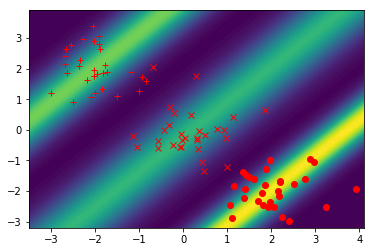

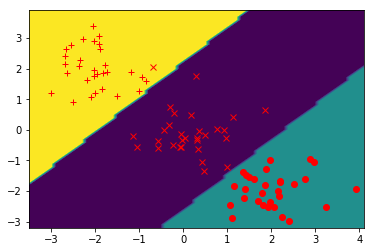

In [14]:
clas = MultiLDAWithPred(X, t, 1)
W = clas.fit()

x_coord = np.arange(-3.5, 4.2, 0.1)
y_coord = np.arange(-3.2, 4, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

### Perceptron

Perceptrons only apply to two classes. It is defined by $$y(\vec{x})-f(\vec{w}^T\vec{\phi}(\vec{x}))$$ where $\vec{\phi}$ is a basis function, and $$f(a)=
    \begin{cases}
      +1, & \text{if}\ a\geq0 \\
      -1, & \text{else}
    \end{cases}$$
    $$\text{(i.e. the signum function)}$$
Using the coding scheme $t\in{\{-1, +1\}}$, we want all patterns to satisfy $\vec{w}^T\vec{\phi}(\vec{x}_n)\vec{t}_n>0 \Leftrightarrow \vec{y}(\vec{x}_n)=t_n$.<br>
Our goal is to minimize the error $$E_p(\vec{w})=-\sum_{n\in{M}}\vec{w}^T\vec{\phi}_nt_n$$ where $M$ is the set of misclassified patterns. Then using stochastic gradient descent (on misclassified patterns),
$$\vec{w}^{(\tau+1)}=\vec{w}^{(\tau)}+\eta\nabla E_p(\vec{w})=\vec{w}^{(\tau)}+\eta\vec{\phi}_nt_n$$
where $\eta$ is the learning rate parameter that we can set to 1 WLOG, and $\tau$ is the iteration number. This can all be interpreted as 
$$\text{For each } \vec{x}_n, y(\vec{x}_n):
    \begin{cases}
      \text{correct: do nothing}\\
      \text{incorrect: }\begin{cases}
                          \text{add } \vec{\phi}_n \text{onto weight vector if } C_1\\
                          \text{subtract }\vec{\phi}_n \text{onto weight vector if } C_2
                        \end{cases}
    \end{cases}
$$

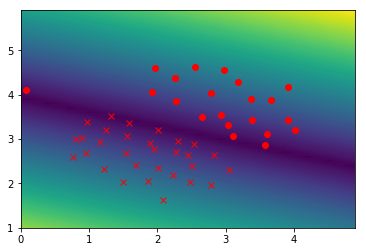

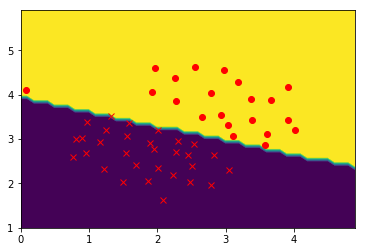

In [15]:
class Perceptron:
    def __init__(self, X, t):
        """
        Initializes Perceptron object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.t = t*2 - 1  # convert to -1, 1
        self.w = None

    def fit(self):
        """
        Computes parameters for model.
        Returns:
            w (float ndarray): weight parameters
        """
        N, D = self.X.shape
        self.w = np.zeros((D, 1))
        while not all(np.sign(self.X.dot(self.w)) == self.t):
            for n in range(N):
                x = self.X[[n]].reshape(-1, 1)
                if np.sign(self.w.T.dot(x)) != self.t[n]:
                    self.w += x*self.t[n]
        return self.w

    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w is not None, 'Need to fit first.'
        x = np.hstack((np.ones((x.shape[0], 1)), x))
        y = x.dot(self.w)[0]
        pred, val = np.sign(y), np.abs(y)
        return pred, val

file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

    
clas = Perceptron(X, t)
clas.fit()

x_coord = np.arange(0, 5, 0.1)
y_coord = np.arange(1, 6, 0.1)
plot_contour_both(plt, x_coord, y_coord, clas)

Perceptron convergence theorem: If there exists a solution (i.e. dataset is linearly separable), then this algorithm will find one.

## Probabilistic Generative Models

With probabilistic generative models, our approach is to model the class-conditional densities $p(\vec{x}|C_k)$ and priors $p(C_k)$ in order to compute the posteriors $p(C_k|\vec{x})$. In the following examples, we use Gaussian mixture models as the generative approach.

### Two classes

We want to classify the following dataset:

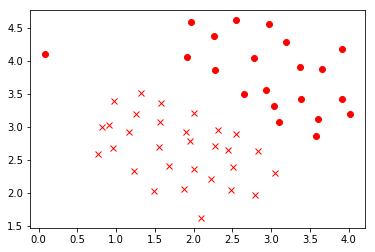

In [16]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

Using Bayes' theorem, the posterior for $C_1$ can be written as $$p(\vec{x}|C_1)=\frac{p(\vec{x}|C_1)p(C_1)}{p(\vec{x})} = \frac{p(\vec{x}|C_1)p(C_1)}{p(\vec{x}|C_1)p(C_1)+p(\vec{x}|C_2)p(C_2)} = \frac{1}{1+e^{-a}} = \sigma(a)$$ where $a=\log \frac{p(\vec{x}|C_1)p(C_1)}{p(\vec{x}|C_2)p(C_2)}=\frac{p(\vec{x},C_1)}{p(\vec{x},C_2)}$. <br>
We assume that all class-conditional densities are Gaussian and all classes share the same covariance. We have the class conditional density as: 
$$p(\vec{x}|C_k)=\frac{1}{(2\pi)^{\frac{D}{2}}} \frac{1}{|\Sigma|^{1/2}}e^{-\frac{1}{2}(\vec{x}-\vec{\mu}_k)^T\Sigma^{-1}(\vec{x}-\vec{\mu}_k)}$$ The posterior for $C_1$ then can be written as 
$$p(C_1|\vec{x})=\sigma(\vec{w}^T\vec{x}+w_0)$$
where
$$\vec{w}=\Sigma^{-1}(\vec{\mu}_1-\vec{\mu}_2)$$
$$w_0=-\frac{1}{2}\vec{\mu}_1^T\Sigma^{-1}\vec{\mu}_1+\frac{1}{2}\vec{\mu}_2^T\Sigma^{-1}\vec{\mu}_2+\log \frac{p(C_1)}{p(C_2)}$$ 
<br>
To find these parameters, we turn to maximum likelihood. Suppose we have a dataset $\{\vec{x}_n,t_n\}$ for $n=1,...,N$ and $t_n=1$ for $C_1$ and $t_n=0$ for $C_2$. Set the priors $p(C_1)=\pi$ and $p(C_2)=1-\pi$. The densities are then given by
$$p(\vec{x}_n,C_1)=p(C_1)p(\vec{x}_n|C_1)=\pi\mathcal{N}(\vec{x}_n|\vec{\mu}_1,\Sigma)$$
$$p(\vec{x}_n,C_2)=p(C_2)p(\vec{x}_n|C_2)=(1-\pi)\mathcal{N}(\vec{x}_n|\vec{\mu}_2,\Sigma)$$
and the likelihood function is given by
$$p(\mathbf{t},\mathbf{X})|\pi,\vec{\mu}_1, \vec{\mu}_2, \Sigma)=\prod_{n=1}^N[\pi\mathcal{N}(\vec{x}_n|\vec{\mu}_1,\Sigma)]^{t_n}[(1-\pi)\mathcal{N}(\vec{x}_n|\vec{\mu}_2,\Sigma)]^{1-t_n}$$
Maximizing this function:
$$\text{w.r.t.} \pi: \Rightarrow \pi=\frac{N_1}{N_1+N_2}$$
$$\text{w.r.t.} \vec{\mu}_1: \Rightarrow \vec{\mu}_1=\frac{1}{N_1}\sum_{n=1}^Nt_n\vec{x}_n$$
$$\text{w.r.t.} \vec{\mu}_2: \Rightarrow \vec{\mu}_2=\frac{1}{N_2}\sum_{n=1}^N(1-t_n)\vec{x}_n$$
$$\text{w.r.t.} \Sigma=\frac{N_1}{N}\mathbf{S}_1+\frac{N_2}{N}\mathbf{S}_2$$
where $\mathbf{S}_1=\frac{1}{N_1}\sum_{n\in{C_1}}(\vec{x}_n-\vec{\mu}_1)(\vec{x}_n-\vec{\mu}_1)^T$ and $\mathbf{S}_2=\frac{1}{N_2}\sum_{n\in{C_2}}(\vec{x}_n-\vec{\mu}_2)(\vec{x}_n-\vec{\mu}_2)^T$.

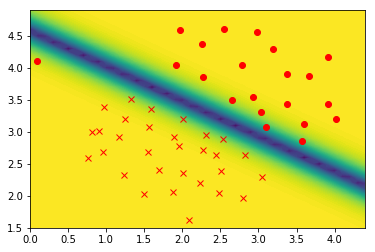

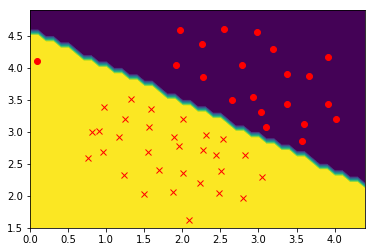

In [17]:
class BinaryGMM:
    def __init__(self, X, t):
        """
        Initializes Binary Gaussian Mixture Model classifier object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.t = t
        self.X1 = X[np.where(t==0)[0], :]
        self.X2 = X[np.where(t==1)[0], :]
        self.N1, self.N2 = self.X1.shape[0], self.X2.shape[0]
        self.N = self.N1 + self.N2
        self.w_0 = None
        self.w = None

    def _get_prior_mean_cov(self):
        """
        Computes prior, means and covariance
        Returns:
            prior (float): prior for first class
            m1 (float ndarray): mean of first class
            m2 (float ndarray): mean of second class
            S (float ndarray): total covariance
        """
        prior = self.N1/self.N
        m1 = np.average(self.X1, axis=0).reshape(-1, 1)
        m2 = np.average(self.X2, axis=0).reshape(-1, 1)
        S1 = (1/self.N1) * (self.X1-m1.T).T.dot((self.X1-m1.T))
        S2 = (1/self.N2) * (self.X2-m2.T).T.dot((self.X2-m2.T))
        S = (self.N1/self.N) * S1 + (self.N2/self.N) * S2
        return prior, m1, m2, S

    def _sigmoid(self, a):
        return 1/(1+np.exp(-a))

    def fit(self):
        """
        Gets weight parameters.
        Returns:
            w_0 (float): bias weight
            w (float ndarray): weights
        """
        prior, m1, m2, S = self._get_prior_mean_cov()
        self.w_0 = -0.5*m1.T.dot(np.linalg.inv(S)).dot(m1) + \
                    0.5*m2.T.dot(np.linalg.inv(S)).dot(m2) + \
                        np.log(prior/(1-prior))
        self.w = np.linalg.inv(S).dot(m1-m2)
        return self.w_0, self.w
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w_0 is not None, 'Need to fit first.'
        y = self._sigmoid(x.dot(self.w)[0] + self.w_0)
        pred, val = np.round(y), np.abs(y - (y < 0.5))
        return pred, val

clas = BinaryGMM(X, t)
clas.fit()

x_coord = np.arange(0, 4.5, 0.1)
y_coord = np.arange(1.5, 5, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

### >2 Classes

Suppose we want to extend Gaussian mixture models to more than two classes.

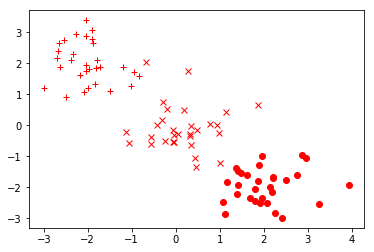

In [18]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

This extension is pretty straightforward. Instead of using the sigmoid function, we use the softmax function. 
$$p(\vec{x}|C_k)=\frac{p(\vec{x}|C_k)p(C_k)}{p(\vec{x})} = \frac{p(\vec{x}|C_k)p(C_k)}{\sum_jp(\vec{x}|C_j)p(C_j)} = \frac{e^{a_k}}{\sum_je^{a_j}}$$
where $a_k=\log{p(\vec{x}|C_k)p(C_k)}$. <br>
The posterior for $C_k$ then can be written as 
$$p(C_k|\vec{x})=\frac{e^{a_k}}{\sum_je^{a_j}}$$
$$\text{where } a_k(\vec{x})=\vec{w}_k^T\vec{x}+w_{k_0}$$
and $\vec{w}_k=\Sigma^{-1}\vec{\mu}_k$ and $w_{k_0}=-\frac{1}{2}\vec{\mu}_k^T\Sigma^{-1}\vec{\mu}_k+\log{p(C_k)}$.

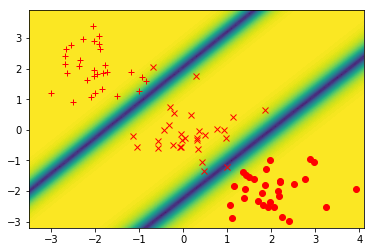

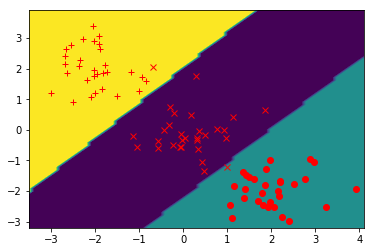

In [19]:
class MultiGMM:
    def __init__(self, X, t):
        """
        Initializes Binary Gaussian Mixture Model classifier object.
        Args:
            X (float ndarray): training data input
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.N, self.D = X.shape
        self.X_all = {c:X[np.where(t==c)[0], :] for c in np.unique(t)}
        self.t = t
        self.N_all = {c:self.X_all[c].shape[0] for c in np.unique(t)}
        self.w_0_all = None
        self.w_all = None

    def _get_prior_mean_cov(self):
        """
        Computes prior, means and covariance
        Returns:
            prior_all (dictionary{float:float}): priors for all classes
            mu_all (dictionary{float:float}): means for all classes
            S_all (dictionary{float:float ndarray}): covariances for all classes
        """
        prior_all = {c:self.N_all[c]/self.N for c in np.unique(self.t)}
        m_all = {c:np.average(self.X_all[c], axis=0).reshape(-1, 1) for c in np.unique(self.t)}
        S_all = {c:(1/self.N_all[c]) * (self.X_all[c]-m_all[c].T).T.dot(self.X_all[c]-m_all[c].T)
                 for c in np.unique(self.t)}
        S = np.zeros((self.D, self.D))
        for c in np.unique(self.t):
            S += (self.N_all[c]/self.N) * S_all[c]
        return prior_all, m_all, S

    def _softmax(self, a):
        total = np.sum(np.exp(a))
        return np.exp(a) / total

    def fit(self):
        """
        Computes weight parameters.
        Returns:
            w_0 (dictionary{float:float}): bias weight for all classes
            w (dictionary{float:float ndarray}): weights for all classes
        """
        prior_all, m_all, S = self._get_prior_mean_cov()
        self.w_all = {c:np.linalg.inv(S).dot(m_all[c]) for c in np.unique(self.t)}
        self.w_0_all = {c:-0.5*m_all[c].T.dot(np.linalg.inv(S)).dot(m_all[c])
                        + np.log(prior_all[c]) for c in np.unique(self.t)}
        return self.w_0_all, self.w_all
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        a = [self.w_all[c].T.dot(x.T).reshape(-1, 1)
             + self.w_0_all[c] for c in sorted(np.unique(self.t))]
        pred, val = np.argmax(a), np.max(self._softmax(a))
        return pred, val


clas = MultiGMM(X, t)
clas.fit()

x_coord = np.arange(-3.5, 4.2, 0.1)
y_coord = np.arange(-3.2, 4, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

Note that if we had discrete features (assume binary for now), we can adopt a Naive Bayes model where class conditionals have the form 
$$p(\vec{x}|C_k)=\prod_{i=1}^D\mu_{k_i}^{x_i}(1-\mu_{k_i})^{1-x_i}$$
which corresponds to posteriors
$$p(C_k|\vec{x})=\frac{e^{a_k(\vec{x})}}{\sum_je^{a_j(\vec{x})}}$$
where $a_k(\vec{x})=\sum_{i=1}^D(x_i\log{\mu_{k_i}}+(1-x_i)\log{1-\mu_{k_i}})) + \log{p(C_k)}$. This is easily extended to nonbinary discrete features.

## Probabilistic Discriminative Models

In probabilistic discriminative models, we determine the weight parameters directly by using maximum likelihood on the functional form of the generalized linear model.

### Logistic Regression

#### Two classes

We first take a look at two class logistic regression. We want to fit this data that we've seen many times before. 

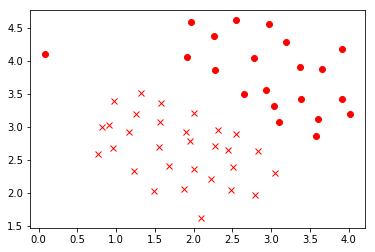

In [20]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'
X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X,t)
plt.show()

As seen before in probabilistic generative models, the posterior probability can be written as logistic sigmoid acting on a linear function:
$$p(C_1|\vec{\phi})=y(\vec{\phi})=\sigma(\vec{w}^T\vec{\phi})$$ where $\vec{\phi}$ is the feature vector. <br>
For a dataset ${\vec{\phi_n}, t_n}$, where $t_n\in {0,1}$ and $\vec{\phi}_n=\vec{\phi}(\vec{x}_n)$, the likelihood function is 
$$p(\mathbf{t}|\vec{w})=\prod_{n=1}^Ny_n^{t_n}(1-y_n)^{1-t_n}$$
where $\mathbf{t}=(t_1,...,t_N)^T$ and $y_n=p(C_1|\vec{\phi}_n)$. The negative log likelihood gives us an error function, and in the case of logistic regression, it is known as the cross-entropy.
$$E(\vec{w})=-\log{p(\mathbf{t}|\vec{w}})=-\sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log{(1-y_n)})$$
Its gradient (w.r.t. $\vec{w}$) is given by:
$$\nabla E(\vec{w})=\sum_{n=1}^N(y_n-t_n)\phi_n$$

Unfortunately, we don't have a closed-form solution. We can use stochastic gradient descent, or an efficient algorithm called the Newton-Raphson method. The idea is that we want to find a weight parameter that is a critical point (the problem is convex). We note that the 2nd order Taylor polynomial of the error function is given by
$$E(\vec{w}+\vec{h})=E(\vec{w})+\nabla E(\vec{w})\vec{h}+\frac{1}{2}\nabla\nabla E(\vec{w})\vec{h}^2$$
We want to find a $\vec{h}$ such that $\nabla E(\vec{w}+\vec{h})=0$. If we differentiate both sides of the Taylor polynomial above w.r.t. $\vec{h}$, we get
$$\frac{\partial{E(\vec{w}+\vec{h})}}{\partial{\vec{h}}} = 0 \Rightarrow \nabla E(\vec{w})+\nabla\nabla E(\vec{w})\vec{h}=0\Rightarrow \vec{h}=-\left(\nabla\nabla E(\vec{w})\right)^{-1}\nabla E(\vec{w})=-\mathbf{H}^{-1}\nabla E(\vec{w})$$ 
where $\mathbf{H}$ is the Hessian (of $E$). The Newton-Raphson method is to update $\vec{w}$ by adding $\vec{h}$ as follows:
$$\vec{w}^{(\text{new})}=\vec{w}^{(\text{old})}-\mathbf{H}^{-1}\nabla E(\vec{w})$$
For the example below, we won't be using a basis function (except for adding the bias term). However, it's still really convenient to include the basis utility we constructed for linear regression.

In [21]:
class BasisUtil:
    def __init__(self, basis_name='polynomial', **kwargs):
        """
        Initializes basis utility.
        Args:
            basis_name (string): either 'gaussian', 'polynomial', or 'none'
            **kwargs: parameters for kernels
        """
        self.basis_name = basis_name
        self.parameters = kwargs

    def dm(self, X):
        """
        Constructs design matrix.
        Args:
            X (float ndarray): dataset or data point
        Returns:
            dm (float ndarray): design matrix
        """
        # Default parameters
        self.parameters.setdefault('M', 3)
        self.parameters.setdefault('m', np.arange(0, 1.01, .1))
        self.parameters.setdefault('s', .1)
        if self.basis_name == 'polynomial':
            def poly_basis(X, M):
                """
                Generates design matrix based off polynomial basis
                Args:
                    X (float ndarray): dataset or data point
                    M (int): number of basis functions/degree
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                dm = np.ones((N, M+1))
                for d in range(M+1):
                    dm[:, [d]] = X**d
                return dm
            return poly_basis(X, self.parameters['M'])
        if self.basis_name == 'gaussian':
            def gaussian_basis(X, m, s):
                """
                Generates design matrix based off Gaussian basis
                Args:
                    X (float ndarray): dataset or data point
                    m (float ndarray): means
                    s (float): variance
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                M = len(m) + 1
                dm = np.ones((N, M))
                for i in range(1, M):
                    dm[:, [i]] = np.exp(-(X-m[i-1])**2/(2*s**2))
                return dm
            return gaussian_basis(X, self.parameters['m'], self.parameters['s'])
        if self.basis_name == 'none':
            def no_basis(X):
                """
                Generates design matrix with no basis
                Args:
                    X (float ndarray): dataset or data point
                Returns:
                    dm (float ndarray): design matrix
                """
                N = X.shape[0]
                dm = np.hstack((np.ones((N, 1)), X))
                return dm
            return no_basis(X)
        raise ValueError('invalid kernel name')

In [22]:
class BinaryLR:
    def __init__(self, X, t, basis_name='none', **kwargs):
        """
        Initializes binary logistic regression classifier object.
        Args:
            dm (float ndarray): design matrix
            t (float ndarray): target values (t:{0, 1,...})
            basis_name (string): name of basis
            **kwargs: parameters for basis
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.D = self.dm.shape
        self.t = t
        self.w = None

    def _sigmoid(self, a):
        """
        Sigmoid function.
        Args:
            a (float ndarray): input value
        Returns:
            (float): sigmoidal value of a
        """
        return 1/(1+np.exp(-a))

    def _grad_error(self, w, lam=0):
        """
        Computes gradient of error.
        Args:
            w (float ndarray): compute gradient at this point
        Returns:
            (float): gradient of error at w
        """
        return self.dm.T.dot(self._sigmoid(self.dm.dot(w)) - self.t) + lam*w

    def _hessian(self, w):
        """
        Computer Hessian of error.
        Args:
            w (float ndarray): compute Hessian at this point
        Returns:
            (float ndarray): Hessian of error at w
        """
        R = np.diag((self._sigmoid(self.dm.dot(w))
                     * (1 - self._sigmoid(self.dm.dot(w)))).ravel())
        return self.dm.T.dot(R).dot(self.dm)
    
    def fit(self, maxiter = 10, lam=0):
        """
        Computes weight parameters.
        Returns:
            w (float ndarray): weight parameters
        """
        self.w = np.zeros((self.D, 1))
        for _ in range(maxiter):
            grad = self._grad_error(self.w, lam=lam) 
            hess = self._hessian(self.w)
            self.w -= np.linalg.inv(hess).dot(grad)
        return self.w
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w is not None, 'Need to fit first.'
        x = self.basis_util.dm(x)
        y = self._sigmoid(self.w.T.dot(x.T))
        pred, val = np.round(y), np.abs(y - (y < 0.5))
        return pred, val

clas = BinaryLR(X, t)

In [23]:
clas.fit(50)

c:\users\alvin\python36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


LinAlgError: Singular matrix

To optimize, we tried 50 iterations, but we got a overflow error that resulted in a singular matrix. This is because maximum likelihood can exhibit severe overfitting for data set that are linearly separable. Notice below how even after just 10 iterations, $\vec{w}$ is already huge.

In [24]:
clas.fit(10)
clas.w

array([[-252.78607388],
       [  22.44606198],
       [  62.33309291]])

To fix this, we can add a prior and find the MAP solution or equivalently add a regularization term to the error function. For simplicity's sake, we'll just add a quadratic regularized to the error.

In [25]:
clas.fit(10, lam=0.03)
clas.w

array([[-15.05513861],
       [  1.64010204],
       [  3.45201256]])

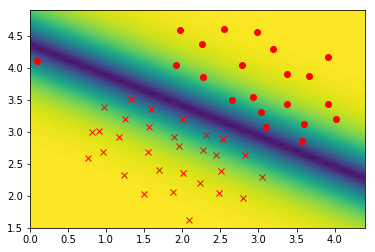

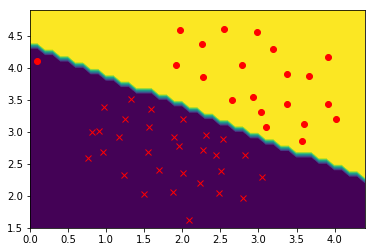

In [26]:
x_coord = np.arange(0, 4.5, 0.1)
y_coord = np.arange(1.5, 5, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

#### >2 Classes

Multiclass logistic regression is fairly similar to the binary case. Suppose we want to fit this dataset. 

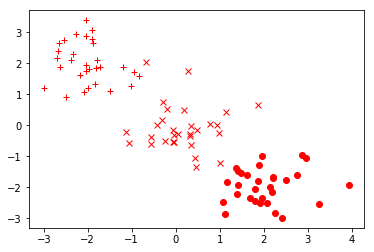

In [27]:
file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set2t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

plot_c_data(plt, X, t)
plt.show()

We first need to make sure our dataset targets follow a 1-of-$K$ coding scheme. Let
$$\mathbf{T}=
\begin{bmatrix}
{-} &  \vec{t_1}^T & -  \\
  &  \vdots &  \\
{-} & \vec{t_N}^T  & -
\end{bmatrix}$$

Instead of the sigmoid activation, we use the softmax function. The posterior is given by
$$p(C_k|\vec{\phi})=y_k(\vec{\phi})=\frac{e^{a_k}}{\sum_je^{a_j}}$$
where $a_k=\vec{w}_k^T\vec{\phi}$. <br>
The maximum likelihood is then given by
$$p(\mathbf{T}|\vec{w}_1,...,\vec{w}_K)=\prod_{n=1}^N\prod_{k=1}^Kp(C_k|\vec{\phi}_n)^{t_{nk}}=\prod_{n=1}^N\prod_{k=1}^Ky_{nk}^{t_{nk}}$$
where $y_{nk}=y_k(\vec{\phi}_n)$. <br>
The cross-entropy error is the negative log likelihood, which is
$$E(\vec{w}_1,...,\vec{w}_k)=-\log{p(\mathbf{T}|\vec{w}_1,...,\vec{w}_K)=-\sum_{n=1}^N\sum_{k=1}^Kt_{nk}\log{y_{nk}}}$$
The gradient w.r.t. $\vec{w}_j$ is
$$\nabla_{\vec{w}_j}E(\vec{w}_1,...,\vec{w}_k)=\sum_{n=1}^N(y_{nj}-t_{nj})\vec{\phi}_n$$

From here, we can proceed with gradient descent. We can also use Newton-Raphson optimization as we did above. The Hessian is composed of blocks of size $M\times M$ where block $j, k$ is
$$\nabla_{\vec{w}_k}\nabla_{\vec{w}_j}E(\vec{w}_1,...,\vec{w}_K)=\sum_{n=1}^Ny_{nk}(\mathbf{I}_{kj}-y_{nj})\vec{\phi}_n\vec{\phi}_n^T$$
though only $\nabla_{\vec{w}_k}\nabla_{\vec{w}_k}E$ is used for the optimization.<br>
Note that $$W=\begin{bmatrix}
 | &   &  | \\
 \vec{w}_1  & \dots & \vec{w}_K \\
 | &   &  |
\end{bmatrix}$$

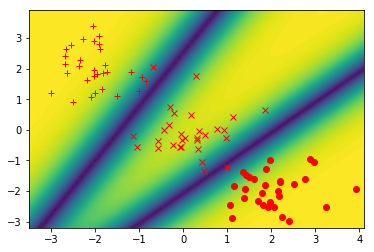

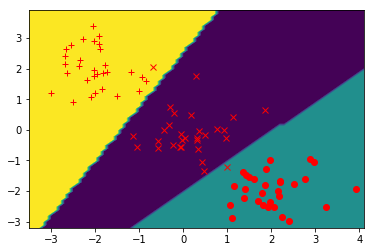

In [28]:
class MultiLR:
    def __init__(self, X, t, basis_name='none', **kwargs):
        """
        Initializes multiclass logistic regression classifier object.
        Args:
            dm (float ndarray): design matrix
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.D = self.dm.shape
        self.K = len(np.unique(t))
        self.T = self._1_of_K(t)
        self.W = None
        
    def _1_of_K(self, t):
        """
        Converts a target array to a 1-of-K coding scheme.
        Args:
            t (float ndarray): target values (t:{0, 1,...})
        Returns:
            T (float ndarray): target values in 1-of-K scheme
        """
        T = np.zeros((self.N, self.K))
        for i in range(self.N):
            T[i, int(t[i])] = 1
        return T

    def _softmax(self, a):
        """
        Softmax function.
        Args:
            a (float ndarray): input value
        Returns:
            (float ndarray): softmax function applied to all values of a
        """
        total = np.sum(np.exp(a), axis = 1).reshape(-1, 1)
        return np.exp(a) / total

    def _grad_k(self, W, k, lam=0):
        """
        Computes gradient of error.
        Args:
            W (float ndarray): weight matrix
            k (int): kth set of weights to compute error on
        Returns:
            (float): gradient of error at W_k
        """
        return (self.dm.T.dot(self._softmax(self.dm.dot(W)) - self.T) + lam*W)[:,[k]]
    
    def _hess_kk(self, W, k):
        """
        Computes Hessian of error.
        Args:
            W (float ndarray): weight
            k (int): kth set of weights to compute error on
        Returns:
            (float): Hessian of error at W_k, W_k
        """
        ans = np.zeros((self.D, self.D))
        for n in range(self.N):
            ykk = self._softmax(self.dm[[n]].dot(W))[0][k]
            ans +=  ykk * (1-ykk) * self.dm[n].reshape(-1, 1).dot(self.dm[[n]])
        return ans

    def fit(self, maxiter=10, lam=0):
        """
        Computes weight parameters.
        Returns:
            W (float ndarray): weight parameters
        """
        self.W = np.zeros((self.D, self.K))
        for _ in range(maxiter):
            for k in range(self.K):
                grad = self._grad_k(self.W, k, lam=lam)
                hess = self._hess_kk(self.W, k)
                self.W[:, [k]] -= np.linalg.pinv(hess).dot(grad)
        return self.W
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.W is not None, 'Need to fit first.'
        x = np.hstack((np.asarray([[1]]), x))
        a = self.W.T.dot(x.T)
        pred, val = np.argmax(a), np.max(self._softmax(a.T))
        return pred, val

clas = MultiLR(X, t)
clas.fit(lam=.3)

x_coord = np.arange(-3.5, 4.2, 0.1)
y_coord = np.arange(-3.2, 4, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

### Probit regression

The posterior given by logistic/softmax transformation is not always suitable if class conditional densities are in more complex forms (e.g. if they are modelled with Gaussian mixture models). We want to motivate an alternative activation function. Consider the two-class case where $p(t=1|a)=f(a)$ where $a=\vec{w}^T\vec{\phi}$ and $f$ is the activation function. Consider the threshold $\theta$, where $t_n = 1$ if $a_n\geq\theta$. If $\theta$ is drawn from a probability density $p(\theta)$, the activation function will be the cumulative distribution function $$f(a)=\int_{-\infty}^ap(\theta)d\theta$$
The probit function is when $p(\theta)$ is a unit variance Gaussian. $$\Phi(a)=\int_{-\infty}^a\mathcal{N}(\theta|0, 1)d\theta$$
Note that using a more general Gaussian distribution won't change the model since it is equivalent to re-scaling the linear coefficients $\vec{w}$. Also note it is related to the `erf` function by the following:
$$\Phi(a)=\frac{1}{2}\left(1+\frac{1}{\sqrt{2}}\text{erf}(a)\right)$$
Probit regression is just logistic regression with a different activation function. It also tends to give similar results as logistic regression, though the probit can be more sensitive to outliers.

We have to compute the error and its gradient and Hessian for this probit function. For a dataset ${\phi_n, t_n}$, where $t_n\in {0,1}$ and $\phi_n=\phi(\vec{x}_n)$, the likelihood function, as before, is 
$$p(\mathbf{t}|\vec{w})=\prod_{n=1}^Ny_n^{t_n}(1-y_n)^{1-t_n}$$
where $\mathbf{t}=(t_1,...,t_N)^T$ and $y_n=p(C_1|\phi_n)$. 
Also as before, the negative log likelihood gives us the error function (cross-entropy).
$$E(\vec{w})=-\log{p(\mathbf{t}|\vec{w}})=-\sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log{(1-y_n)})$$
By noting that the derivative of the probit is the Gaussian $\mathcal{N}(x|0, 1)$, and the derivative of $\mathcal{N}(x|0, 1)$ is $x\mathcal{N}(x|0, 1)$, we can calculate the gradient and Hessian
$$\nabla E(\vec{w})=-\sum_{n=1}^N\left(\frac{t_n}{y_n}-\frac{1-t_n}{1-y_n}\right)\mathcal{N}(y_n|0, 1)\vec{\phi}_n$$
$$\nabla\nabla E(\vec{w})=-\sum_{n=1}^N\left(-\frac{t_n}{y_n^2}-\frac{1-t_n}{(1-y_n)^2}-\left(\frac{t_n}{y_n}-\frac{1-t_n}{1-y_n}\right)\vec{w}^T\vec{\phi}_n\right)\mathcal{N}(y_n|0, 1)\vec{\phi}_n\vec{\phi}_n^T$$

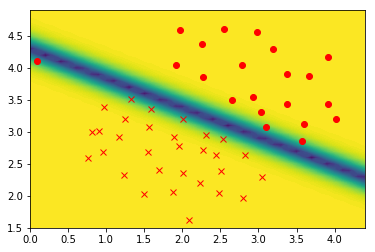

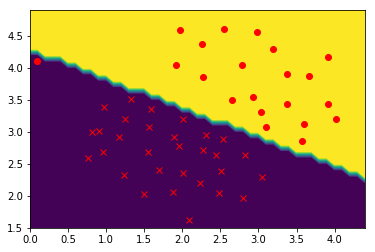

In [29]:
from scipy.stats import norm as sv_gauss
from scipy.special import erf

class BinaryPR:
    def __init__(self, X, t, basis_name='none', **kwargs):
        """
        Initializes binary probit regression classifier object.
        Args:
            dm (float ndarray): design matrix
            t (float ndarray): target values (t:{0, 1,...})
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.D = self.dm.shape
        self.t = t
        self.w = None

    def _probit(self, a):
        """
        Probit function.
        Args:
            a (float ndarray): input value
        Returns:
            (float ndarray): probit function applied to a
        """
        return 0.5 * (1+(1/2**0.5)*erf(a))

    def _grad_error(self, w, lam=0):
        """
        Computes gradient of error.
        Args:
            w (float ndarray): weight to compute gradient at
            lam (float): regularization coefficient
        Returns:
            (float): gradient of error at w
        """
        y = self._probit(self.dm.dot(w))
        normal = sv_gauss(0, 1)
        return self.dm.T.dot((self.t/y-(1-self.t)/(1-y))*normal.pdf(y)) + lam*w

    def _hessian(self, w):
        """
        Computes Hessian of error.
        Args:
            w (float ndarray): weight to compute Hessian at
        Returns:
            (float ndarray): Hessian of error at w
        """
        y = self._probit(self.dm.dot(w))
        normal = sv_gauss(0, 1)

        R = np.diag(((-self.t/y**2 - (1-self.t)/(1-y)**2 -
                      (self.t/y - (1-self.t)/(1-y)) * self.dm.dot(w)) * normal.pdf(y)**2).ravel())
        return self.dm.T.dot(R).dot(self.dm)
    
    def fit(self, maxiter=5, lam=0):
        """
        Computes weight parameters.
        Returns:
            w (float ndarray): weight parameters
        """
        self.w = np.zeros((self.D, 1))
        for _ in range(maxiter):
            grad = self._grad_error(self.w, lam=lam)
            hess = self._hessian(self.w)
            self.w = self.w - np.linalg.pinv(hess).dot(grad)
        return self.w
    
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w is not None, 'Need to fit first.'
        x = np.hstack((np.asarray([[1]]), x))
        a = self.w.T.dot(x.T)
        y = self._probit(a)
        pred, val = np.round(y), np.abs(y - (y < 0.5))
        return pred, val


file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)

clas = BinaryPR(X, t)
clas.fit()

x_coord = np.arange(0, 4.5, 0.1)
y_coord = np.arange(1.5, 5, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)

Remark: logistic and probit regression assume data is correctly labelled. We can introduce probability $\epsilon$ that $t$ has been mislabeled into $$p(t|\vec{w})=(1-\epsilon)\sigma(\vec{x})+\epsilon(1-\sigma(\vec{x}))=\epsilon+(1-2\epsilon)\sigma(\vec{x})$$ where $\sigma$ is the activation function.

### Bayesian Logistic Regression

Before approaching Bayesian logistic regression, we first need an approximation scheme because we can't directly integrate over $\vec{w}$ since the posterior is not Gaussian. Suppose we want to approximate a $p(\vec{z})=\frac{1}{Z}f(\vec{z})$ where $Z=\int f(\vec{z})d\vec{z}$ is the normalization coefficient. We want to find a Gaussian approximation $q(\vec{z})$ that's centered on the mode of $p(\vec{z})$. Suppose the mode occurs at $\vec{z}_0$, so that $\frac{df(\vec{z})}{d\vec{z}}\rvert_{\vec{z}=\vec{z}_0}$ Then the Taylor expansion of $\log{f(\vec{z})}$ is
$$\log{f(\vec{z})}\simeq\log{f(\vec{z}_0)}-\frac{1}{2}(\vec{z}-\vec{z}_0)^T\mathbf{A}(\vec{z}-\vec{z}_0)$$
So we can approximate $q$ as
$$q(\vec{z})=\mathcal{N}(\vec{z}|\vec{z}_0,\mathbf{A}^{-1})$$
<br>
Suppose we have <br> $\ \ \bullet$prior $p(\vec{w})=\mathcal{N}(\vec{w}|\vec{m}_0,\mathbf{S}_0)$ where $\vec{m}_0, \mathbf{S}_0$ are fixed hyperparameters, <br> $\ \ \bullet$likelihood $p(\vec{t}|\vec{w})=\prod_{n=1}^Ny_n^{t_n}(1-y_n)^{1-t_n}$ where $\vec{t}=(t_1,...,t_n)^T$ and $y_n=\sigma(\vec{w}^T\vec{\phi}_n)$.
<br>Then the log posterior is given by
$$\log{p(\vec{w}|\vec{t})\propto \log(p(\vec{w})p(\vec{t}|\vec{w}))} = -\frac{1}{2}(\vec{w}-\vec{m}_0)^T\mathbf{S}_0^{-1}(\vec{w}-\vec{m}_0) + \sum_{n=1}^N(t_n\log{y_n}+(1-t_n)\log{(1-y_n)}) + \text{const}$$
We can find $\vec{w}_{map}$ by numerical optimization and $\mathbf{S}_N^{-1}$ is given by the inverse of the negative Hessian of the negative likelihood $(\mathbf{S}_N^{-1}=-\nabla\nabla\log{p(\vec{w}|\vec{t})}=\mathbf{S}_0^{-1}+\sum_{n=1}^Ny_n(1-y_n)\vec{\phi}_n\vec{\phi}_n^T)$. <br> <br>
The posterior is therefore estimated by $q(\vec{w})=\mathcal{N}(\vec{w}|\vec{w}_{map}, \mathbf{S}_N)$. 

In [30]:
from scipy.stats import multivariate_normal as mv_gauss


class BinaryBLR:
    def __init__(self, X, t, basis_name = 'none', alpha=1, m_0=None, S_0=None, **kwargs):
        """
        Initializes binary Bayesian logistic regression classifier object.
        Args:
            dm (float ndarray): design matrix
            t (float ndarray): target values (t:{0, 1,...})
            alpha (float): prior hyperparameter 
            m_0 (float ndarray): prior mean
            S_0 (float ndarray): prior covariance
        """
        self.basis_util = BasisUtil(basis_name, **kwargs)
        self.dm = self.basis_util.dm(X)
        self.N, self.D = self.dm.shape
        self.t = t
        self.alpha = alpha
        if m_0 is None: m_0, S_0 = self._default_prior()
        self.m_0 = m_0
        self.S_0 = S_0
        self.w_map = None

    def _default_prior(self):
        """
        Generates a default prior.
        Returns:
            m_0 (float ndarray): default prior mean
            S_0 (float ndarray): default prior covariance
        """
        m_0 = np.zeros((self.D, 1))
        S_0 = 1/self.alpha * np.identity(self.D)
        return m_0, S_0

    def _sigmoid(self, a):
        """
        Sigmoid function.
        Args:
            a (float ndarray): input value
        Returns:
            (float): sigmoidal value of a
        """
        return 1/(1 + np.exp(-a))
    
    def _log_posterior(self, w):
        """
        Compute log posterior.
        Args:
            w (float ndarray): weight parameters
        Returns:
            (float): log posterior at w
        """
        y = self._sigmoid(self.dm.dot(w))
        return -0.5 * (w-self.m_0).T.dot(np.linalg.inv(self.S_0)).dot(w-self.m_0) + \
                       np.sum(self.t*np.log(y)+(1-self.t)*np.log(1-y))

    def _posterior_approx(self):
        """
        Approximates posterior distribution.
        Returns:
            q_w (mv_gauss): multivariate Gaussian approximation for posterior 
        """
        val = 0
        for n in range(self.N):
            yn = self._sigmoid(self.w_map.T.dot(self.dm[n])).reshape(-1, 1)
            val += yn*(1-yn)*self.dm[n].reshape(-1, 1).dot(self.dm[[n]])
        S_N = np.linalg.inv(np.linalg.inv(self.S_0) + val)
        q_w = mv_gauss(self.w_map.ravel(), S_N)
        return q_w

    def fit(self):
        """
        Computes weight parameters.
        Returns:
            w_map (float ndarray): weight parameters
        """
        def decorator(w):
            w = w.reshape(-1, 1)
            return -self._log_posterior(w)[0][0]

        self.w_map = np.zeros((self.D, 1))
        self.w_map = minimize(decorator, self.w_map.ravel()).x.reshape(-1, 1)
        return self.w_map

We can find the predictive distribution $p(C_1|\vec{\phi},\vec{t})$ by integrating out $\vec{w}$ with our approximation.
$$p(C_1|\vec{\phi},\vec{t})=\int p(C_1,\vec{w}|\vec{\phi},\vec{t})=\int p(C_1|\vec{\phi},\vec{w})p(\vec{w}|\vec{t})d\vec{w}\simeq\int \sigma(\vec{w}^T\vec{\phi})q(\vec{w})d\vec{w}$$
If we let $a=\vec{w}^T\vec{\phi}$, we get $\sigma(\vec{w}^T\vec{\phi})=\int\delta(a-\vec{w}^T\vec{\phi})\sigma(a)da$ where $\delta$ is the Dirac delta function, so
$$\int\sigma(\vec{w}^T\vec{\phi})q(\vec{w})d\vec{w}=\int\sigma(a)p(a)da$$ where $p(a)=\int\delta(a-\vec{w}^T\vec{\phi})q(\vec{w})d\vec{w}$.
<br>
We can evaluate $p(a)$ because the delta function only imposes a linear constraint on $\vec{w}$ and since $q(\vec{w})$ is Gaussian, its marginal is also Gaussian.
$$\mu_a=\vec{w}_{map}^T\vec{\phi}$$
$$\sigma_a^2=\vec{\phi}^T\mathbf{S}_N\vec{\phi}$$
So now we have $p(C_1|\vec{\phi}, \vec{t})=\int\sigma(a)\mathcal{N}(a|\mu_a,\sigma_a^2)da$. This still can't be evaluated analytically, but we can approximate using the inverse probit ($\sigma(a)\simeq\Phi(\lambda a) $ with $\lambda^2=\frac{\pi}{8}$). We have the identity $\int\Phi(\lambda a)\mathcal(a|\mu,\sigma^2)da=\Phi\left(\frac{\mu}{(\lambda^{-2}+\sigma^2)^{\frac{1}{2}}}\right)$. Substituting and replacing the inverse probit with sigmoid, we have
$$p(C_1|\vec{\phi},\vec{t})=\int\sigma(a)\mathcal{N}(a|\mu,\sigma^2)da\simeq\sigma(\kappa(\sigma^2)\mu)$$ where $\kappa(\sigma^2)=(1+\frac{\pi}{8}\sigma^2)^{-\frac{1}{2}}$.

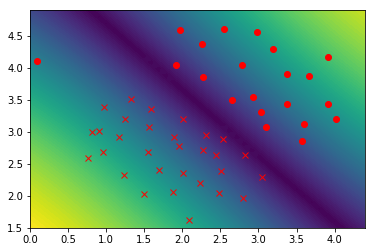

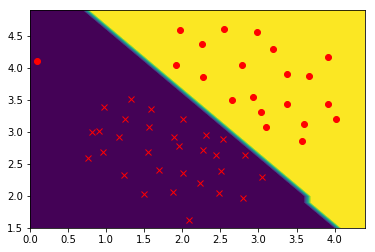

In [31]:
class BinaryBLRWithPred(BinaryBLR):
    def pred(self, x):
        """
        Predicts value for input value.
        Args:
            x (float ndarray): single input value
        Returns:
            pred (float): the predicted class 
            val (float): corresponding value of predicted class
        """
        assert self.w_map is not None, 'Need to fit first.'
        x = np.hstack((np.asarray([[1]]), x))
        S_N = self._posterior_approx().cov
        m_a = self.w_map.T.dot(x.T)
        s_a = x.dot(S_N).dot(x.T)
        p = self._sigmoid(m_a*(1 + (np.pi*s_a**2)/8)**-0.5)
        pred, val = np.round(p), np.abs(p - (p < 0.5))
        return pred, val


file_name_X = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1X.csv'
file_name_t = 'C:\\Users\\Alvin\\Google Drive\\CS\\ML-DL\\Examples\\data\\set1t.csv'

X = np.loadtxt(file_name_X, delimiter=',')
t = np.loadtxt(file_name_t, delimiter=',').reshape(-1, 1)
N = X.shape[0]
D = X.shape[1]

clas = BinaryBLRWithPred(X, t)
clas.fit()

x_coord = np.arange(0, 4.5, 0.1)
y_coord = np.arange(1.5, 5, 0.1)

plot_contour_both(plt, x_coord, y_coord, clas)